In [1]:
!pip install torch-geometric

In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
df=pd.read_csv("/content/creditcard_2023.csv")
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [4]:
df.shape

(568630, 31)

In [5]:
# Step 2: Stratified Sampling (10,000 rows with similar class distribution)
df_sampled, _ = train_test_split(df, train_size=10000, stratify=df['Class'], random_state=42)
df_sampled.reset_index(drop=True, inplace=True)

In [6]:
# Count the values in the 'Class' column
fraud_counts = df_sampled['Class'].value_counts()

# Print counts
print("Transaction counts:")
print(fraud_counts)

# Optional: Show percentages
print("\nPercentages:")
print(fraud_counts / len(df_sampled) * 100)

Transaction counts:
Class
0    5000
1    5000
Name: count, dtype: int64

Percentages:
Class
0    50.0
1    50.0
Name: count, dtype: float64


In [7]:
# 2. Preprocessing
X = df_sampled.drop(columns=['Class'])
y = df_sampled['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Step 4: KNN Graph Construction
from sklearn.neighbors import NearestNeighbors
import torch

k = 10  # You can tune this for sparsity vs connectivity
nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

edge_index = []
for i in range(len(X_scaled)):
    for j in indices[i][1:]:  # Skip self-loop
        edge_index.append([i, j])
        edge_index.append([j, i])  # undirected edge

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

In [9]:
# Step 5: Convert to PyTorch Geometric Data Object
from torch_geometric.data import Data
import torch

x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

In [10]:
# Step 6: Train/Test Split
from torch_geometric.utils import train_test_split_edges
from sklearn.model_selection import train_test_split

train_mask, test_mask = train_test_split(range(len(y)), test_size=0.2, stratify=y, random_state=42)

train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

In [11]:
# Step 7: Build the GNN Model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Module

class GCN(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(input_dim=x.shape[1], hidden_dim=16, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
# Step 8: Training Loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [13]:
# Step 9: Evaluation
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[test_mask] == data.y[test_mask]
    acc = int(correct.sum()) / len(test_mask)
    return acc

In [14]:
# Step 10: Run Training
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        acc = test()
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

Epoch 20, Loss: 0.1162, Test Accuracy: 0.9595
Epoch 40, Loss: 0.0589, Test Accuracy: 0.9810
Epoch 60, Loss: 0.0342, Test Accuracy: 0.9915
Epoch 80, Loss: 0.0212, Test Accuracy: 0.9965
Epoch 100, Loss: 0.0147, Test Accuracy: 0.9965
Epoch 120, Loss: 0.0115, Test Accuracy: 0.9970
Epoch 140, Loss: 0.0097, Test Accuracy: 0.9965
Epoch 160, Loss: 0.0086, Test Accuracy: 0.9975
Epoch 180, Loss: 0.0079, Test Accuracy: 0.9975
Epoch 200, Loss: 0.0073, Test Accuracy: 0.9975


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

def evaluate_model():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    y_true = data.y[test_mask].cpu().numpy()
    y_pred = pred[test_mask].cpu().numpy()
    y_proba = F.softmax(out[test_mask], dim=1)[:, 1].detach().cpu().numpy()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
    disp.plot(cmap='Blues')

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

    # ROC-AUC
    auc = roc_auc_score(y_true, y_proba)
    print(f"ROC-AUC Score: {auc:.4f}")



Classification Report:
               precision    recall  f1-score   support

           0     0.9970    0.9980    0.9975      1000
           1     0.9980    0.9970    0.9975      1000

    accuracy                         0.9975      2000
   macro avg     0.9975    0.9975    0.9975      2000
weighted avg     0.9975    0.9975    0.9975      2000

ROC-AUC Score: 1.0000


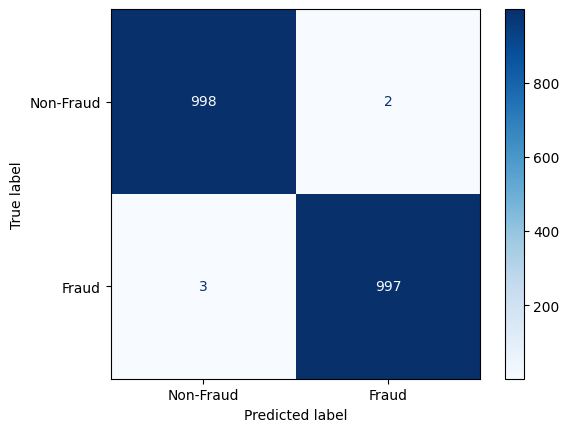

In [16]:
evaluate_model()

In [17]:
fraud_indices = (data.y == 1).nonzero(as_tuple=True)[0]
print(fraud_indices[:5])  # pick any index for explanation

tensor([ 1,  2,  6,  8, 12])
